In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import iqr
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
import catboost as cb
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# Outcome

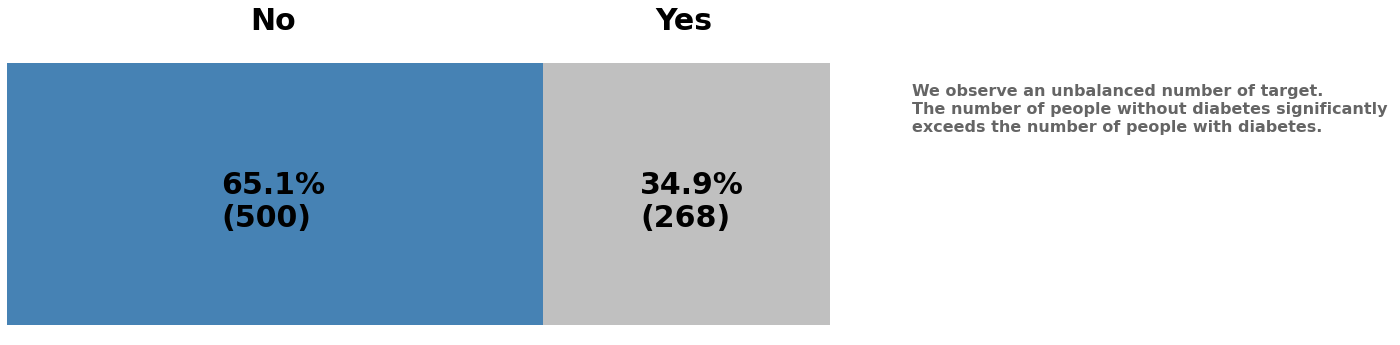

In [4]:
group_Outcome= df.groupby('Outcome')['Pregnancies'].count().reset_index()
group_Outcome.rename(columns={'Pregnancies':'Count'}, inplace=True)
group_Outcome['Percentages'] = round(group_Outcome['Count']/sum(group_Outcome['Count'])*100,2)

# fig
fig = plt.figure(figsize=(12,4))

# axes
axes = fig.add_axes([0,0,1,1])

# barh
axes.barh(width=group_Outcome['Percentages'][0]+group_Outcome['Percentages'][1], y=0, color='silver')
axes.barh(width=group_Outcome['Percentages'][0], y=0, color='steelblue')

# annotation
axes.text(group_Outcome['Percentages'][0]/2.5, 0, f"{group_Outcome['Percentages'][0]}%", color='black', fontsize=30, fontweight='bold')
axes.text(group_Outcome['Percentages'][0]/2.5, -0.1, f"({group_Outcome['Count'][0]})", color='black', fontsize=30, fontweight='bold')
axes.text((group_Outcome['Percentages'][0]+group_Outcome['Percentages'][1])/1.3, 0, f"{group_Outcome['Percentages'][1]}%", color='black', fontsize=30, fontweight='bold')
axes.text((group_Outcome['Percentages'][0]+group_Outcome['Percentages'][1])/1.3, -0.1, f"({group_Outcome['Count'][1]})", color='black', fontsize=30, fontweight='bold')

# title
axes.text(group_Outcome['Percentages'][0]/2.2, 0.5, 'No', color='Black', fontsize=30, fontweight='bold')
axes.text((group_Outcome['Percentages'][0]+group_Outcome['Percentages'][1])/1.27, 0.5, 'Yes', color='Black', fontsize=30, fontweight='bold')

# conclusion
axes.text(110, 0.3, 'We observe an unbalanced number of target.', fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes.text(110, 0.19, '''The number of people without diabetes significantly 
exceeds the number of people with diabetes.''', fontsize=16, fontweight='bold', color='black', alpha=0.6)

# axis
axes.axis('off')

fig.show()

# Age

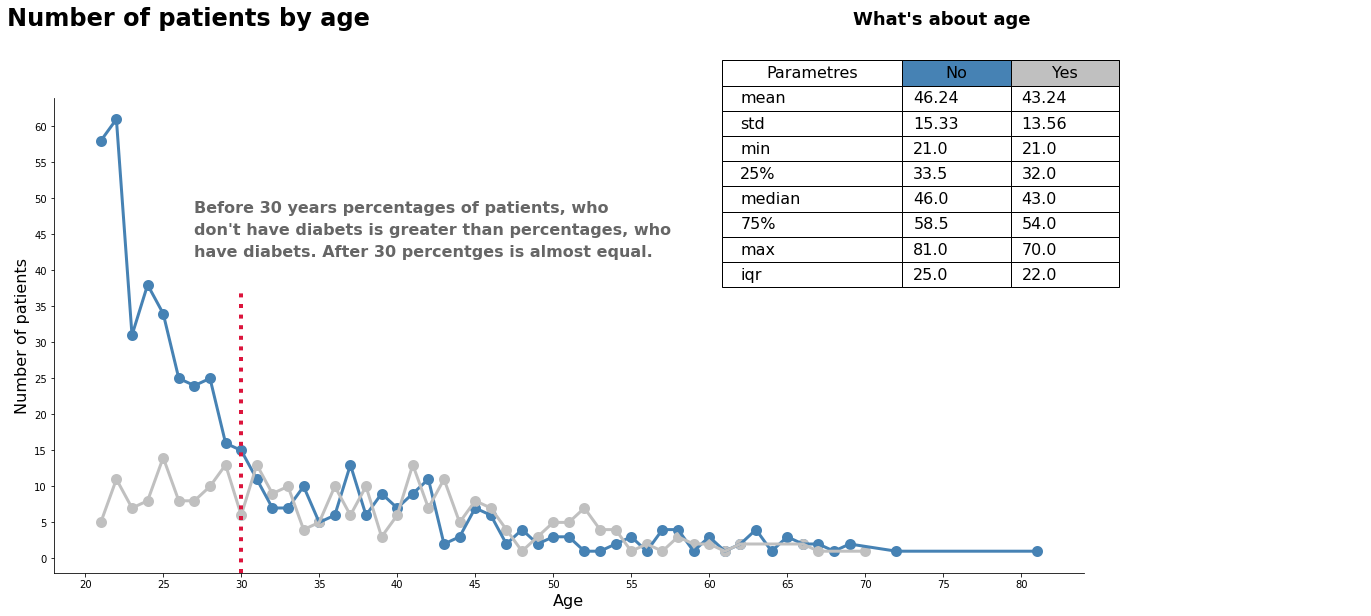

In [5]:
# compare
df_age_no = df[df['Outcome']==0]['Age'].value_counts().to_frame().reset_index()
df_age_no.rename(columns={'index':'Age', 'Age':'Count'}, inplace=True)
df_age_no.sort_values(by='Age', inplace=True)
df_age_no.reset_index(inplace=True)
df_age_no.drop('index', axis=1, inplace=True)

df_age_yes = df[df['Outcome']==1]['Age'].value_counts().to_frame().reset_index()
df_age_yes.rename(columns={'index':'Age', 'Age':'Count'}, inplace=True)
df_age_yes.sort_values(by='Age', inplace=True)
df_age_yes.reset_index(inplace=True)
df_age_yes.drop('index', axis=1, inplace=True)

# table
stats_list_no = []
for x in df_age_no['Age'].describe()[1:]:
    stats_list_no.append(round(x, 2))
stats_list_no.append(iqr(df_age_no['Age']))
stats_list_yes = []
for x in df_age_yes['Age'].describe()[1:]:
    stats_list_yes.append(round(x, 2))
stats_list_yes.append(iqr(df_age_yes['Age']))
parametres_list = ['mean', 'std', 'min', '25%', 'median', '75%', 'max', 'iqr']
df_stats = pd.DataFrame({'Parametres':parametres_list, 'No':stats_list_no, 'Yes':stats_list_yes})
list_ = []
for n in range(len(df_stats)):
    x = df_stats.loc[n,:]
    list_.append(x)

# colors for table
color_list=[['white', 'white', 'white']]    

# fig
fig = plt.figure(figsize=(13,6))

# axes
axes1 = fig.add_axes([0, 0, 1.1, 1.1])
axes2 = fig.add_axes([0.7, 0.5, 0.7, 0.7]) 

# line
sns.lineplot(x=df_age_no['Age'], y=df_age_no['Count'], ax=axes1, color='steelblue', lw=3)
sns.lineplot(x=df_age_yes['Age'], y=df_age_yes['Count'], ax=axes1, color='silver', lw=3)

# scatter
axes1.scatter(x=df_age_no['Age'], y=df_age_no['Count'], color='steelblue', lw=5)
axes1.scatter(x=df_age_yes['Age'], y=df_age_yes['Count'], color='silver', lw=5)

# lines
axes1.axvline(30, ymin=0, ymax=0.6, linestyle=':', lw=4, color='crimson')

# spines
axes1.spines[['right', 'top']].set_visible(False)

# ticks
axes1.set_xticks(range(20, 85, 5))
axes1.set_yticks(range(0, 65, 5))

# labels
axes1.set_xlabel('Age', fontsize=16, color='black')
axes1.set_ylabel('Number of patients', fontsize=16, color='black')

# annotate
axes1.text(27, 48, 'Before 30 years percentages of patients, who', fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes1.text(27, 45, "don't have diabets is greater than percentages, who", fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes1.text(27, 42, 'have diabets. After 30 percentges is almost equal.', fontsize=16, fontweight='bold', color='black', alpha=0.6)
 
# title
axes1.text(15, 74, 'Number of patients by age', fontsize=24, color='black', fontweight='bold')

# table
axes2.set_axis_off() 
table=axes2.table(cellColours=color_list*8,cellText = list_, cellLoc ='left', loc ='upper left', colWidths=[0.25, 0.15, 0.15],
                  colLabels=df_stats.columns,colColours=['white', 'steelblue', 'silver'])           
table.auto_set_font_size(False) 
table.set_fontsize(16)  
table.scale(1.1, 2.1) 
axes2.text(0.22, 1.1, "What's about age", color='black', fontsize=18, fontweight='bold')

fig.show()

# Pregnancies
**What I want to know:**

* Ratio of percentages in Pregnancies by Outcome
* Ratio of percentages in Outcome by Pregnancies

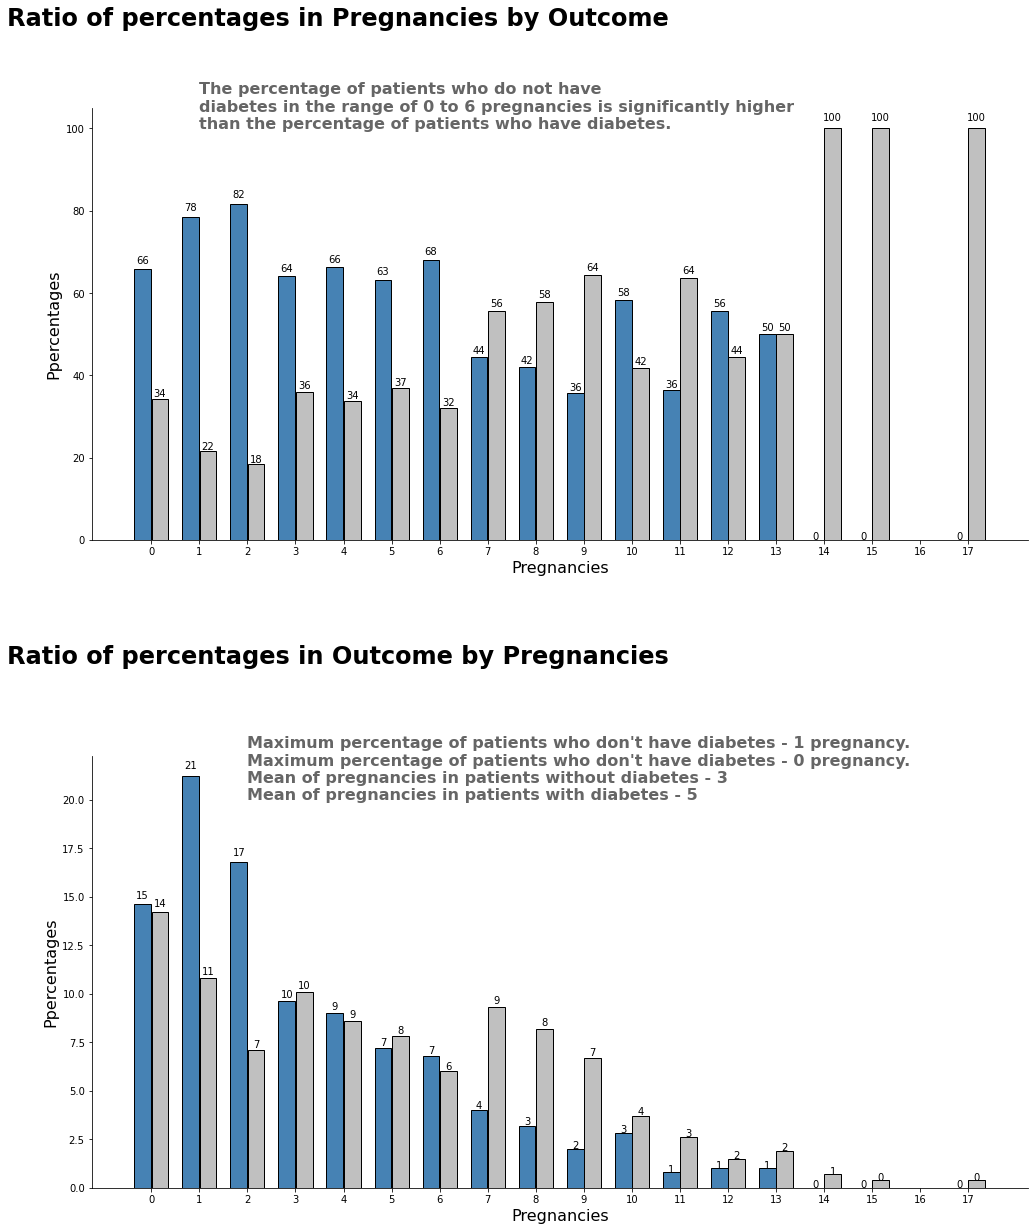

In [6]:
# crosstab
cross_Pregnancies = pd.crosstab(df['Pregnancies'], df['Outcome'], margins=True)
cross_Pregnancies['Percentages_no'] = round(cross_Pregnancies[0]/cross_Pregnancies['All']*100, 1)
cross_Pregnancies['Percentages_yes'] = round(cross_Pregnancies[1]/cross_Pregnancies['All']*100, 1)

# percentages of Pregnancies
perecetges_list_no = []
for x in cross_Pregnancies[0][:17]:
    i = round(x/cross_Pregnancies[0]['All'] * 100, 1)
    perecetges_list_no.append(i)

perecetges_list_yes = []
for x in cross_Pregnancies[1][:17]:
    i = round(x/cross_Pregnancies[1]['All'] * 100, 1)
    perecetges_list_yes.append(i)

# fig
fig = plt.figure(figsize=(13,6))

# axes
axes1 = fig.add_axes([0, 0, 1, 1])
axes2 = fig.add_axes([0, -1.5, 1, 1])

# bar
axes1.bar(height=cross_Pregnancies['Percentages_no'][:17], x=cross_Pregnancies.index[:17]-0.18, width=0.35, color='steelblue', edgecolor='black')
axes1.bar(height=cross_Pregnancies['Percentages_yes'][:17], x=cross_Pregnancies.index[:17]+0.18, width=0.35, color='silver', edgecolor='black')
axes2.bar(height=perecetges_list_no, x=cross_Pregnancies.index[:17]-0.18, width=0.35, color='steelblue', edgecolor='black')
axes2.bar(height=perecetges_list_yes, x=cross_Pregnancies.index[:17]+0.18, width=0.35, color='silver', edgecolor='black')

# ticks
axes1.set_xticks(range(0,18,1))
axes2.set_xticks(range(0,18,1))

# annotates
for p in axes1.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes1.annotate('{:.0f}'.format(height), (x + width/2, y + height*1.02), ha='center') 
for p in axes2.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axes2.annotate('{:.0f}'.format(height), (x + width/2, y + height*1.02), ha='center')

# spines
axes1.spines[['top', 'right']].set_visible(False)
axes2.spines[['top', 'right']].set_visible(False)

# labels
axes1.set_xlabel('Pregnancies', fontsize=16, color='black')
axes1.set_ylabel('Ppercentages', fontsize=16, color='black')
axes2.set_xlabel('Pregnancies', fontsize=16, color='black')
axes2.set_ylabel('Ppercentages', fontsize=16, color='black')

# title
axes1.text(-3, 125, 'Ratio of percentages in Pregnancies by Outcome', color='black', fontsize=24, fontweight='bold')
axes2.text(-3, 27, 'Ratio of percentages in Outcome by Pregnancies', color='black', fontsize=24, fontweight='bold')

# annotate 
axes1.text(1, 100, '''The percentage of patients who do not have 
diabetes in the range of 0 to 6 pregnancies is significantly higher 
than the percentage of patients who have diabetes.''', fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes2.text(2, 20, f'''Maximum percentage of patients who don't have diabetes - 1 pregnancy.
Maximum percentage of patients who don't have diabetes - 0 pregnancy.
Mean of pregnancies in patients without diabetes - {round(df[df['Outcome']==0]['Pregnancies'].mean())}
Mean of pregnancies in patients with diabetes - {round(df[df['Outcome']==1]['Pregnancies'].mean())}''', fontsize=16, fontweight='bold', color='black', alpha=0.6)

fig.show()

# Glucose

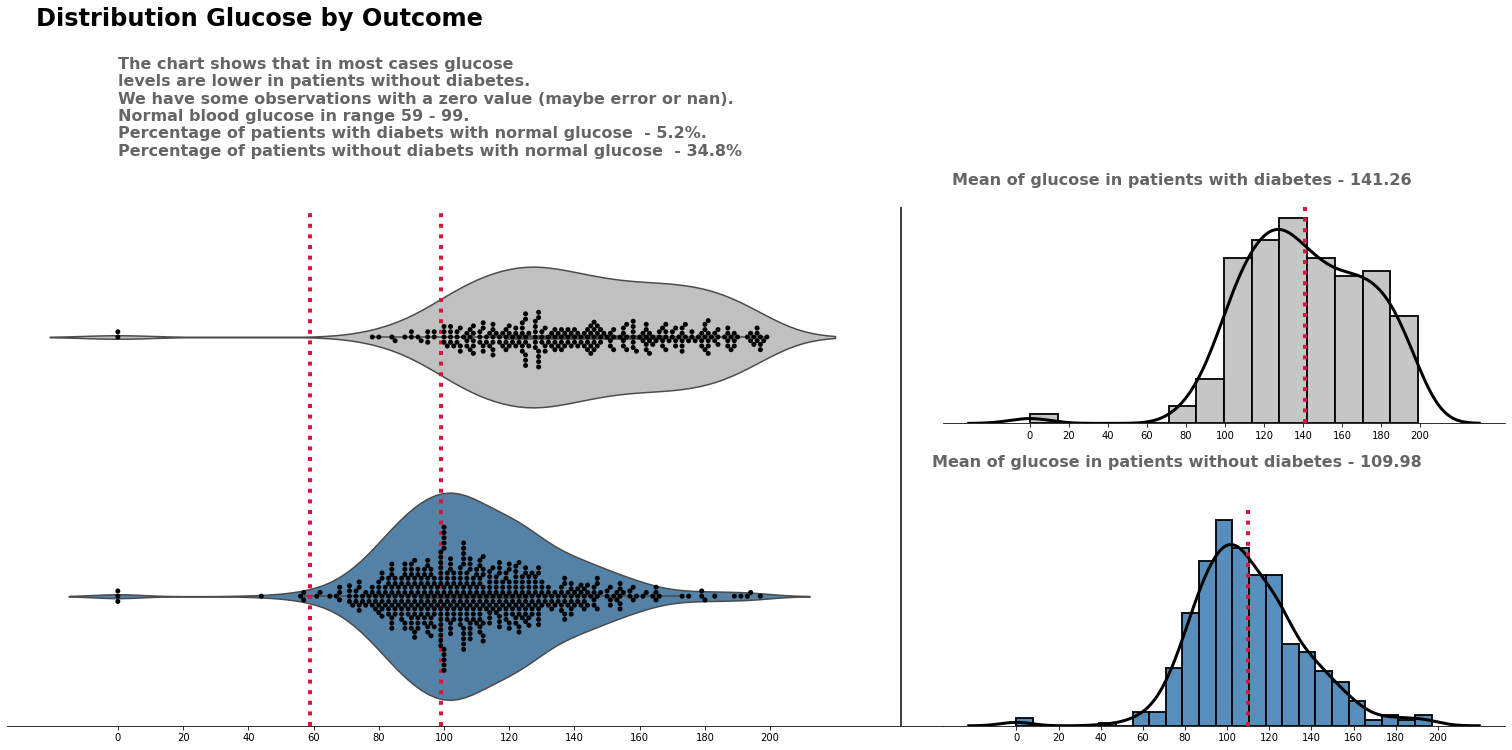

In [7]:
df['Outcome'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)

# fig
fig = plt.figure(figsize=(13, 6))

# axes
axes1 = fig.add_axes([0, 0, 1, 1.2])
axes2 = fig.add_axes([1, 0, 0.6, 0.5])
axes3 = fig.add_axes([1, 0.7, 0.6, 0.5])

# violin
sns.violinplot(y=df['Outcome'], x=df['Glucose'], palette=['silver', 'steelblue'], ax=axes1)

# swarm
sns.swarmplot(y=df['Outcome'], x=df['Glucose'], palette=['black', 'black'], ax=axes1)

# distplot
sns.distplot(x=df[df['Outcome']=='Yes']['Glucose'], ax=axes3,  hist_kws = dict(alpha=0.9, edgecolor='black', lw=2), 
             color='silver', kde_kws=dict(color='black', lw=3))
sns.distplot(x=df[df['Outcome']=='No']['Glucose'], ax=axes2,  hist_kws = dict(alpha=0.9, edgecolor='black', lw=2), 
             color='steelblue', kde_kws=dict(color='black', lw=3))

# lines
axes1.axvline(240, ymin=0, ymax=1, color='black')
axes1.axvline(59, ymin=0, ymax=1, color='crimson', lw=4, linestyle=':')
axes1.axvline(99, ymin=0, ymax=1, color='crimson', lw=4, linestyle=':')
axes3.axvline(df[df['Outcome']=='Yes']['Glucose'].mean(), ymin=0, ymax=1, lw=4, color='crimson', linestyle=':')
axes2.axvline(df[df['Outcome']=='No']['Glucose'].mean(), ymin=0, ymax=1, lw=4, color='crimson', linestyle=':')

# spines
axes1.spines[['right', 'left', 'top']].set_visible(False)
axes2.spines[['right', 'left', 'top']].set_visible(False)
axes3.spines[['right', 'left', 'top']].set_visible(False)

# labels
axes1.set_xlabel('')
axes2.set_xlabel('')
axes3.set_xlabel('')
axes1.set_ylabel('')
axes2.set_ylabel('')
axes3.set_ylabel('')

# ticks
axes1.set_xticks(range(0, 220, 20))
axes2.set_xticks(range(0, 220, 20))
axes3.set_xticks(range(0, 220, 20))
axes1.set_yticks([])
axes2.set_yticks([])
axes3.set_yticks([])

# annotate
axes1.text(0, -0.7, f'''The chart shows that in most cases glucose 
levels are lower in patients without diabetes.
We have some observations with a zero value (maybe error or nan).
Normal blood glucose in range 59 - 99.
Percentage of patients with diabets with normal glucose  - {round(len(df[df['Outcome']=='Yes'][df[df['Outcome']=='Yes']['Glucose']>=59][df[df['Outcome']=='Yes'][df[df['Outcome']=='Yes']['Glucose']>=59]['Glucose']<=99])/len(df[df['Outcome']=='Yes'])*100, 1)}%.
Percentage of patients without diabets with normal glucose  - {len(df[df['Outcome']=='No'][df[df['Outcome']=='No']['Glucose']>=59][df[df['Outcome']=='No'][df[df['Outcome']=='No']['Glucose']>=59]['Glucose']<=99])/len(df[df['Outcome']=='No'])*100}%''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes2.text(-40, 0.024, f'''Mean of glucose in patients without diabetes - {round(df[df['Outcome']=='No']['Glucose'].mean(), 2)}''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes3.text(-40, 0.014, f'''Mean of glucose in patients with diabetes - {round(df[df['Outcome']=='Yes']['Glucose'].mean(), 2)}''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)

# title
axes1.text(-25, -1.2, 'Distribution Glucose by Outcome', color='black', fontsize=24, fontweight='bold')

fig.show()

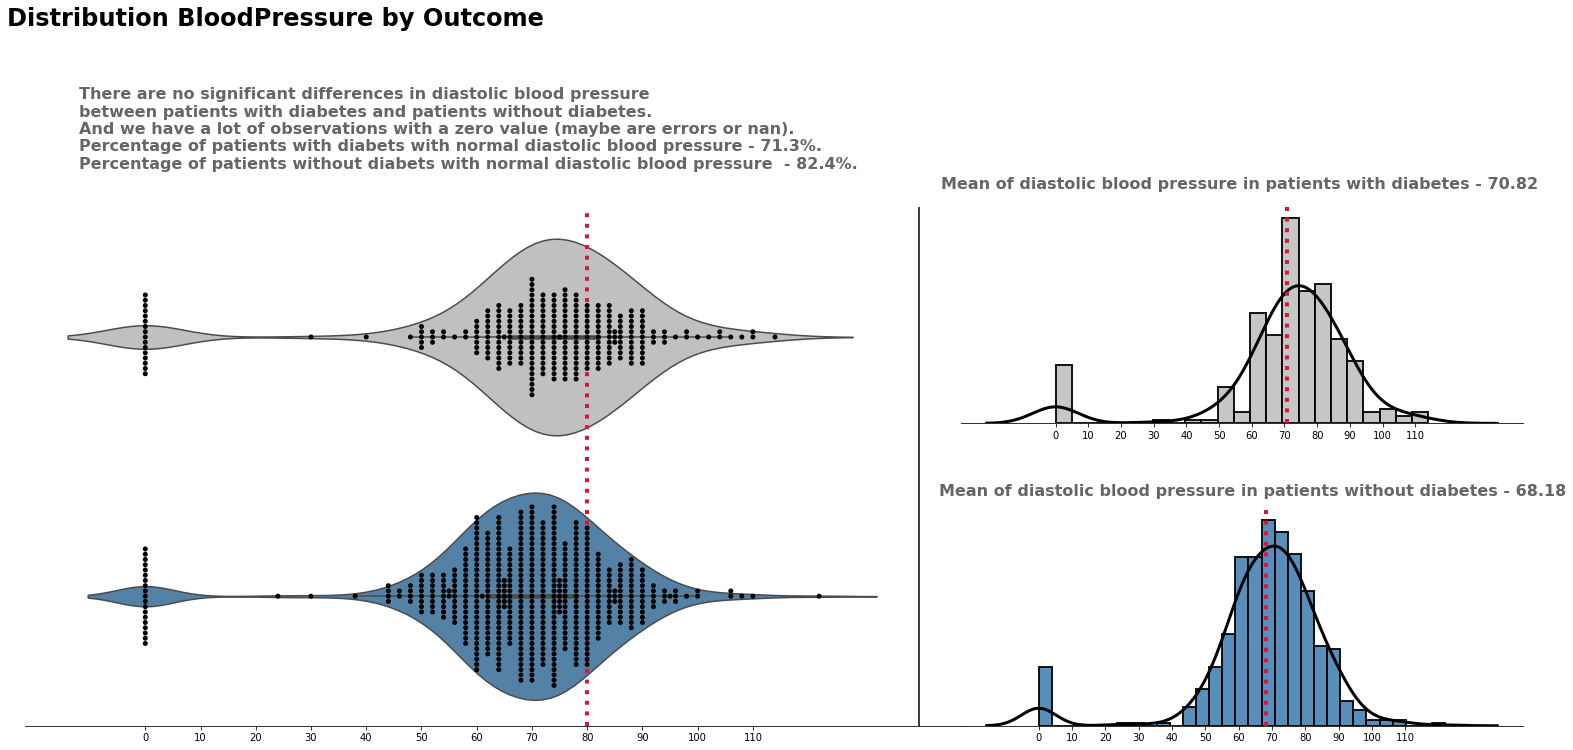

In [8]:
# fig
fig = plt.figure(figsize=(13, 6))

# axes
axes1 = fig.add_axes([0, 0, 1, 1.2])
axes2 = fig.add_axes([1, 0, 0.6, 0.5])
axes3 = fig.add_axes([1, 0.7, 0.6, 0.5])

# violin
sns.violinplot(y=df['Outcome'], x=df['BloodPressure'], palette=['silver', 'steelblue'], ax=axes1)

# swarm
sns.swarmplot(y=df['Outcome'], x=df['BloodPressure'], palette=['black', 'black'], ax=axes1)

# distplot
sns.distplot(x=df[df['Outcome']=='No']['BloodPressure'], ax=axes2,  hist_kws = dict(alpha=0.9, edgecolor='black', lw=2), 
             color='steelblue', kde_kws=dict(color='black', lw=3))
sns.distplot(x=df[df['Outcome']=='Yes']['BloodPressure'], ax=axes3,  hist_kws = dict(alpha=0.9, edgecolor='black', lw=2), 
             color='silver', kde_kws=dict(color='black', lw=3))

# lines
axes1.axvline(140, ymin=0, ymax=1, color='black')
axes1.axvline(80, ymin=0, ymax=1, color='crimson', lw=4, linestyle=':')
axes3.axvline(df[df['Outcome']=='Yes']['BloodPressure'].mean(), ymin=0, ymax=1, lw=4, color='crimson', linestyle=':')
axes2.axvline(df[df['Outcome']=='No']['BloodPressure'].mean(), ymin=0, ymax=1, lw=4, color='crimson', linestyle=':')

# spines
axes1.spines[['right', 'left', 'top']].set_visible(False)
axes2.spines[['right', 'left', 'top']].set_visible(False)
axes3.spines[['right', 'left', 'top']].set_visible(False)

# labels
axes1.set_xlabel('')
axes2.set_xlabel('')
axes3.set_xlabel('')
axes1.set_ylabel('')
axes2.set_ylabel('')
axes3.set_ylabel('')

# ticks
axes1.set_xticks(range(0, 120, 10))
axes2.set_xticks(range(0, 120, 10))
axes3.set_xticks(range(0, 120, 10))
axes1.set_yticks([])
axes2.set_yticks([])
axes3.set_yticks([])

# annotate 
axes1.text(-12, -0.65, f'''There are no significant differences in diastolic blood pressure
between patients with diabetes and patients without diabetes.
And we have a lot of observations with a zero value (maybe are errors or nan).
Percentage of patients with diabets with normal diastolic blood pressure - {round(len(df[df['Outcome']=='Yes'][df[df['Outcome']=='Yes']['BloodPressure']<=80])/len(df[df['Outcome']=='Yes'])*100, 1)}%.
Percentage of patients without diabets with normal diastolic blood pressure  - {round(len(df[df['Outcome']=='No'][df[df['Outcome']=='No']['BloodPressure']<=80])/len(df[df['Outcome']=='No'])*100, 1)}%.''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes2.text(-30, 0.038, f'''Mean of diastolic blood pressure in patients without diabetes - {round(df[df['Outcome']=='No']['BloodPressure'].mean(), 2)}''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes3.text(-35, 0.048, f'''Mean of diastolic blood pressure in patients with diabetes - {round(df[df['Outcome']=='Yes']['BloodPressure'].mean(), 2)}''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)

# title
axes1.text(-25, -1.2, 'Distribution BloodPressure by Outcome', color='black', fontsize=24, fontweight='bold')

fig.show()

# SkinThickness

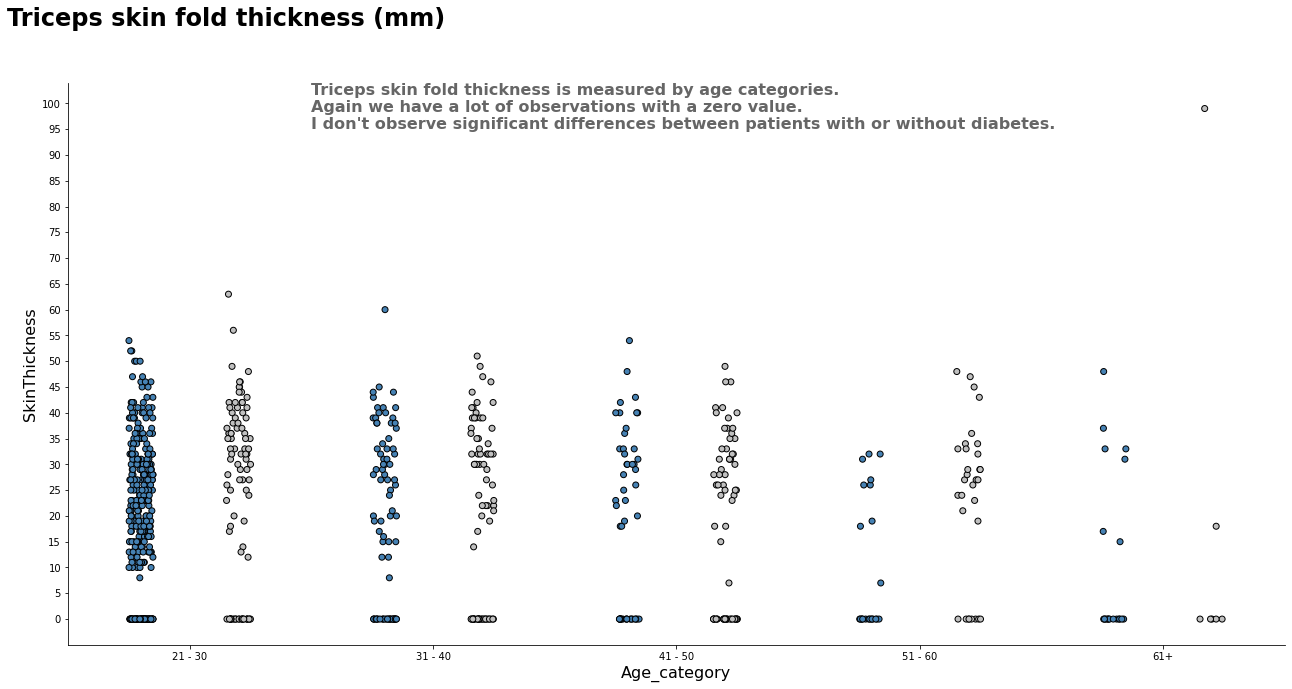

In [9]:
# age category
df['Age_category'] = pd.cut(df['Age'], [20, 30, 40, 50, 60, 100])
df['Age_category'] = df['Age_category'].astype('str')
df['Age_category'].value_counts()
df['Age_category'].replace({'(20, 30]' : '21 - 30', '(30, 40]' : '31 - 40', '(40, 50]' : '41 - 50', '(50, 60]' : '51 - 60', '(60, 100]' : '61+'}, inplace=True)
df_sort_age_category = df.sort_values(by='Age_category')

# fig
fig = plt.figure(figsize=(13, 6))

# axes
axes = fig.add_axes([0, 0, 1.3, 1.3])

# stripplot
sns.stripplot(y=df_sort_age_category['SkinThickness'], x=df_sort_age_category['Age_category'], 
              hue=df_sort_age_category['Outcome'], palette=['steelblue', 'silver'], dodge=True, size=6, 
              linewidth=1, edgecolor='black', ax=axes)

# legend
axes.legend().set_visible(False)

# spines
axes.spines[['top', 'right']].set_visible(False)

# ticks
axes.set_yticks(range(0, 101, 5))

# labels
axes.set_xlabel('Age_category', fontsize=16, color='black')
axes.set_ylabel('SkinThickness', fontsize=16, color='black')

# annotate
axes.text(0.5, 95, '''Triceps skin fold thickness is measured by age categories.
Again we have a lot of observations with a zero value.
I don't observe significant differences between patients with or without diabetes.''', fontsize=16, fontweight='bold', color='black', alpha=0.6)

# title
axes.text(-0.75, 115, 'Triceps skin fold thickness (mm)', color='black', fontsize=24, fontweight='bold')

fig.show()

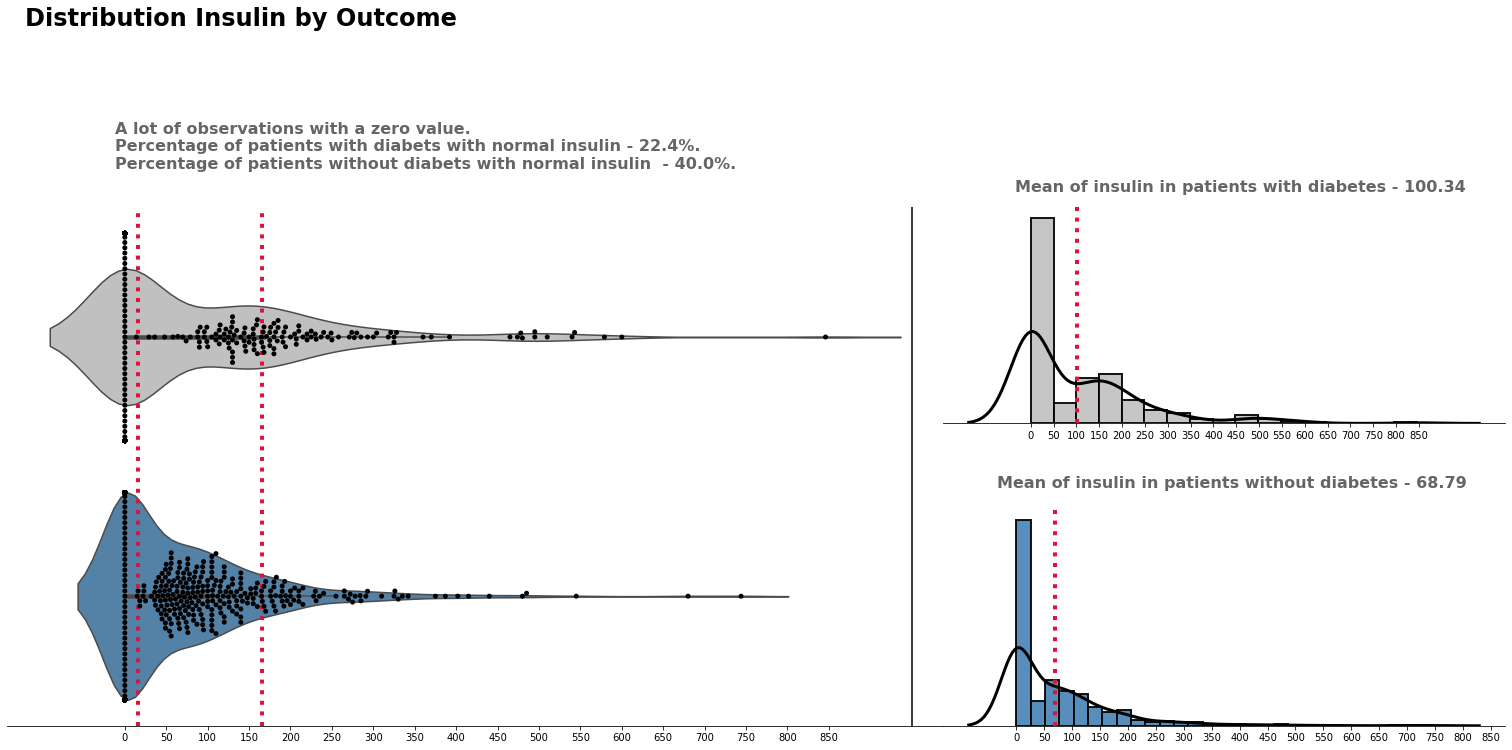

In [10]:
# fig
fig = plt.figure(figsize=(13, 6))

# axes
axes1 = fig.add_axes([0, 0, 1, 1.2])
axes2 = fig.add_axes([1, 0, 0.6, 0.5])
axes3 = fig.add_axes([1, 0.7, 0.6, 0.5])

# violin
sns.violinplot(y=df['Outcome'], x=df['Insulin'], palette=['silver', 'steelblue'], ax=axes1)

# swarm
sns.swarmplot(y=df['Outcome'], x=df['Insulin'], palette=['black', 'black'], ax=axes1)

# distplot
sns.distplot(x=df[df['Outcome']=='No']['Insulin'], ax=axes2,  hist_kws = dict(alpha=0.9, edgecolor='black', lw=2), 
             color='steelblue', kde_kws=dict(color='black', lw=3))
sns.distplot(x=df[df['Outcome']=='Yes']['Insulin'], ax=axes3,  hist_kws = dict(alpha=0.9, edgecolor='black', lw=2), 
             color='silver', kde_kws=dict(color='black', lw=3))

# lines
axes1.axvline(950, ymin=0, ymax=1, color='black')
axes1.axvline(16, ymin=0, ymax=1, color='crimson', lw=4, linestyle=':')
axes1.axvline(166, ymin=0, ymax=1, color='crimson', lw=4, linestyle=':')
axes3.axvline(df[df['Outcome']=='Yes']['Insulin'].mean(), ymin=0, ymax=1, lw=4, color='crimson', linestyle=':')
axes2.axvline(df[df['Outcome']=='No']['Insulin'].mean(), ymin=0, ymax=1, lw=4, color='crimson', linestyle=':')

# spines
axes1.spines[['right', 'left', 'top']].set_visible(False)
axes2.spines[['right', 'left', 'top']].set_visible(False)
axes3.spines[['right', 'left', 'top']].set_visible(False)

# labels
axes1.set_xlabel('')
axes2.set_xlabel('')
axes3.set_xlabel('')
axes1.set_ylabel('')
axes2.set_ylabel('')
axes3.set_ylabel('')

# ticks
axes1.set_xticks(range(0, 851, 50))
axes2.set_xticks(range(0, 851, 50))
axes3.set_xticks(range(0, 851, 50))
axes1.set_yticks([])
axes2.set_yticks([])
axes3.set_yticks([])

# annotate 
axes1.text(-12, -0.65, f'''A lot of observations with a zero value.
Percentage of patients with diabets with normal insulin - {round(len(df[df['Outcome']=='Yes'][df[df['Outcome']=='Yes']['Insulin']>=16][df[df['Outcome']=='Yes'][df[df['Outcome']=='Yes']['Insulin']>=16]['Insulin']<=166]['Insulin'])/len(df[df['Outcome']=='Yes'])*100, 1)}%.
Percentage of patients without diabets with normal insulin  - {len(df[df['Outcome']=='No'][df[df['Outcome']=='No']['Insulin']>=16][df[df['Outcome']=='No'][df[df['Outcome']=='No']['Insulin']>=16]['Insulin']<=166]['Insulin'])/len(df[df['Outcome']=='No'])*100}%. ''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes2.text(-35, 0.022, f'''Mean of insulin in patients without diabetes - {round(df[df['Outcome']=='No']['Insulin'].mean(), 2)}''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes3.text(-35, 0.012, f'''Mean of insulin in patients with diabetes - {round(df[df['Outcome']=='Yes']['Insulin'].mean(), 2)}''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)

# title
axes1.text(-120, -1.2, 'Distribution Insulin by Outcome', color='black', fontsize=24, fontweight='bold')

fig.show()

# BMI

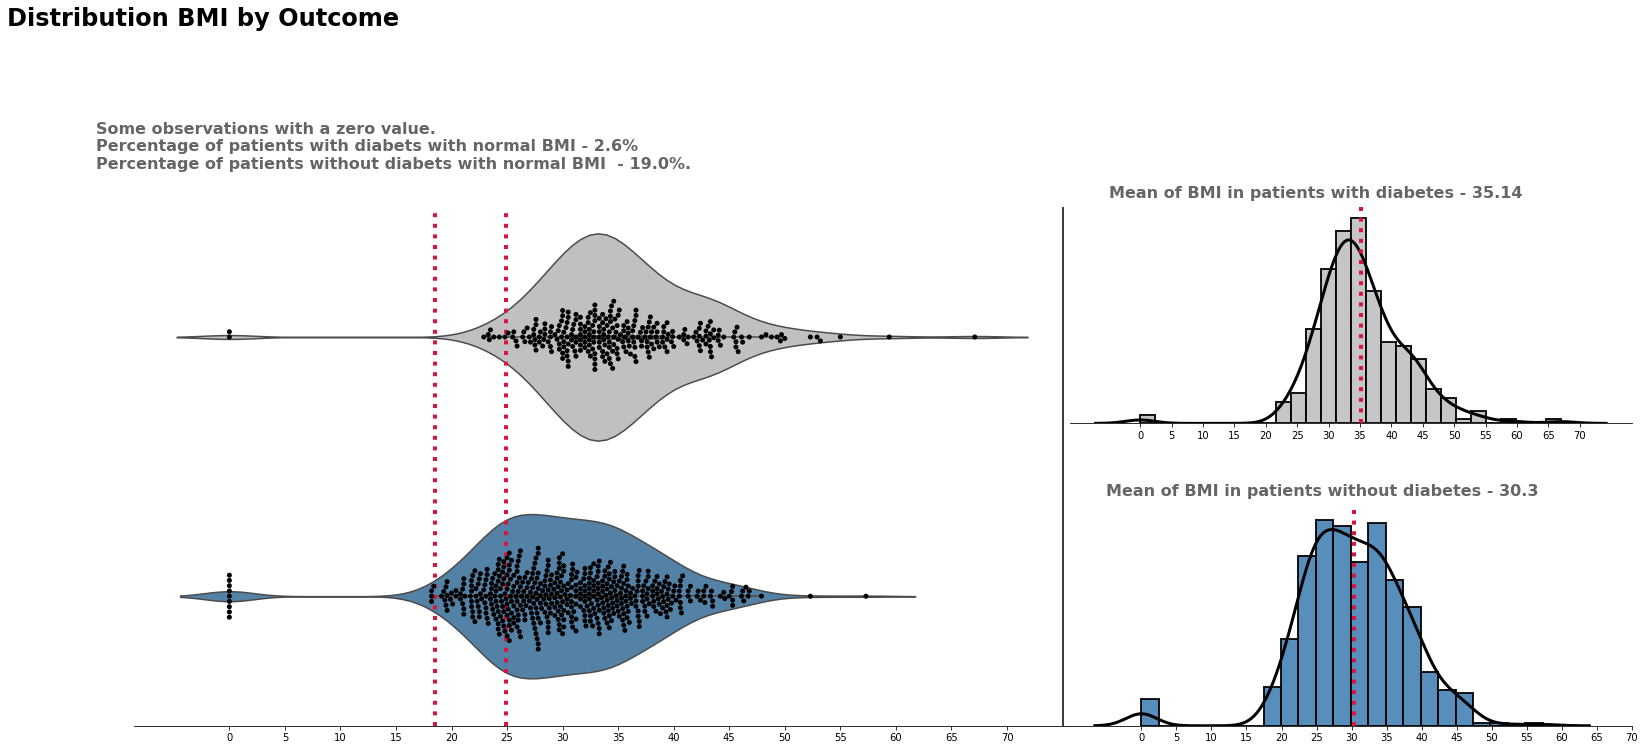

In [11]:
# fig
fig = plt.figure(figsize=(13, 6))

# axes
axes1 = fig.add_axes([0, 0, 1, 1.2])
axes2 = fig.add_axes([1, 0, 0.6, 0.5])
axes3 = fig.add_axes([1, 0.7, 0.6, 0.5])

# violin
sns.violinplot(y=df['Outcome'], x=df['BMI'], palette=['silver', 'steelblue'], ax=axes1)

# swarm
sns.swarmplot(y=df['Outcome'], x=df['BMI'], palette=['black', 'black'], ax=axes1)

# distplot
sns.distplot(x=df[df['Outcome']=='No']['BMI'], ax=axes2,  hist_kws = dict(alpha=0.9, edgecolor='black', lw=2), 
             color='steelblue', kde_kws=dict(color='black', lw=3))
sns.distplot(x=df[df['Outcome']=='Yes']['BMI'], ax=axes3,  hist_kws = dict(alpha=0.9, edgecolor='black', lw=2), 
             color='silver', kde_kws=dict(color='black', lw=3))

# lines
axes1.axvline(75, ymin=0, ymax=1, color='black')
axes1.axvline(18.5, ymin=0, ymax=1, color='crimson', lw=4, linestyle=':')
axes1.axvline(24.9, ymin=0, ymax=1, color='crimson', lw=4, linestyle=':')
axes3.axvline(df[df['Outcome']=='Yes']['BMI'].mean(), ymin=0, ymax=1, lw=4, color='crimson', linestyle=':')
axes2.axvline(df[df['Outcome']=='No']['BMI'].mean(), ymin=0, ymax=1, lw=4, color='crimson', linestyle=':')

# spines
axes1.spines[['right', 'left', 'top']].set_visible(False)
axes2.spines[['right', 'left', 'top']].set_visible(False)
axes3.spines[['right', 'left', 'top']].set_visible(False)

# labels
axes1.set_xlabel('')
axes2.set_xlabel('')
axes3.set_xlabel('')
axes1.set_ylabel('')
axes2.set_ylabel('')
axes3.set_ylabel('')

# # ticks
axes1.set_xticks(range(0, 75, 5))
axes2.set_xticks(range(0, 75, 5))
axes3.set_xticks(range(0, 75, 5))
axes1.set_yticks([])
axes2.set_yticks([])
axes3.set_yticks([])

# annotate 
axes1.text(-12, -0.65, f'''Some observations with a zero value.
Percentage of patients with diabets with normal BMI - {round(len(df[df['Outcome']=='Yes'][df[df['Outcome']=='Yes']['BMI']>=18.5][df[df['Outcome']=='Yes'][df[df['Outcome']=='Yes']['BMI']>=18.5]['BMI']<=24.9]['BMI'])/len(df[df['Outcome']=='Yes'])*100, 1)}%
Percentage of patients without diabets with normal BMI  - {len(df[df['Outcome']=='No'][df[df['Outcome']=='No']['BMI']>=18.5][df[df['Outcome']=='No'][df[df['Outcome']=='No']['BMI']>=18.5]['BMI']<=24.9]['Insulin'])/len(df[df['Outcome']=='No'])*100}%. ''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes2.text(-5, 0.062, f'''Mean of BMI in patients without diabetes - {round(df[df['Outcome']=='No']['BMI'].mean(), 2)}''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes3.text(-5, 0.082, f'''Mean of BMI in patients with diabetes - {round(df[df['Outcome']=='Yes']['BMI'].mean(), 2)}''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)

# title
axes1.text(-20, -1.2, 'Distribution BMI by Outcome', color='black', fontsize=24, fontweight='bold')

fig.show()

# DiabetesPedigreeFunction

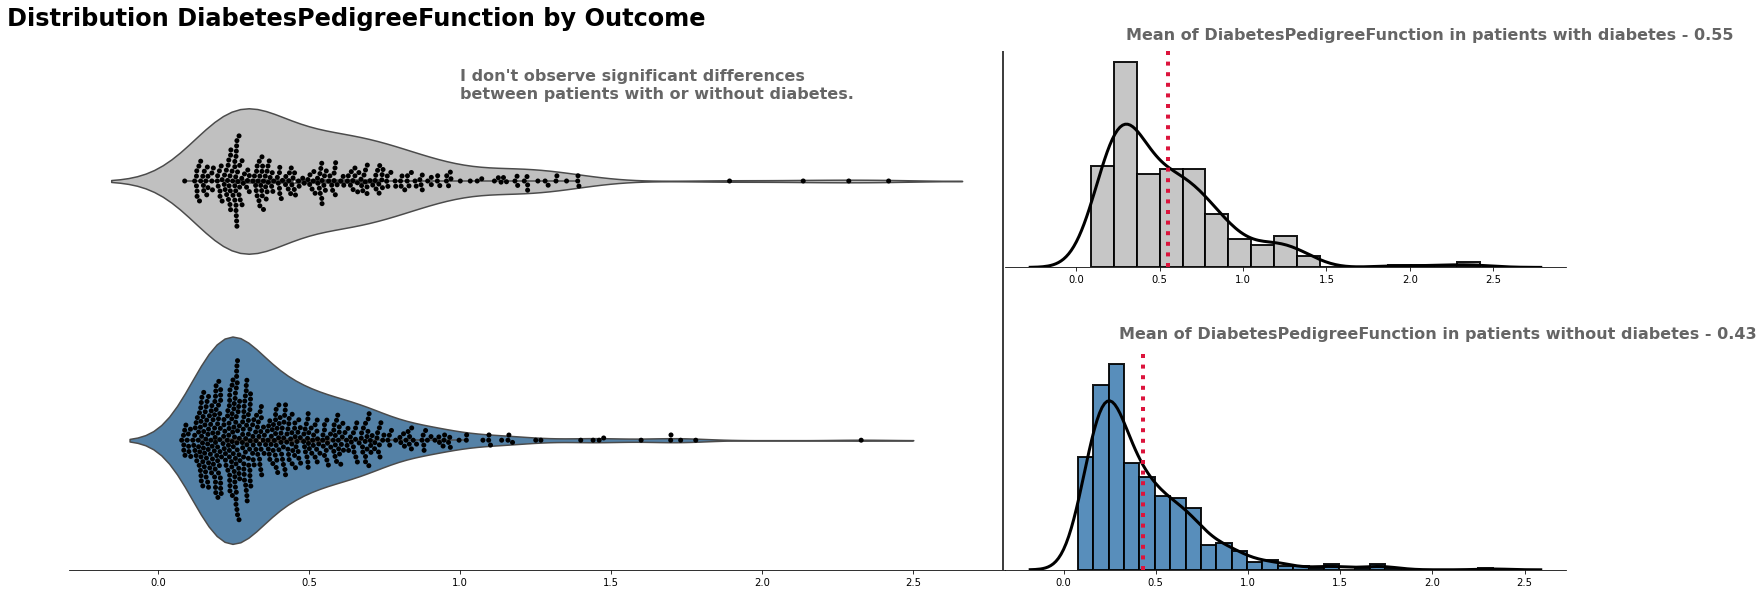

In [12]:
# fig
fig = plt.figure(figsize=(13, 6))

# axes
axes1 = fig.add_axes([0, 0, 1, 1.2])
axes2 = fig.add_axes([1, 0, 0.6, 0.5])
axes3 = fig.add_axes([1, 0.7, 0.6, 0.5])

# violin
sns.violinplot(y=df['Outcome'], x=df['DiabetesPedigreeFunction'], palette=['silver', 'steelblue'], ax=axes1)

# swarm
sns.swarmplot(y=df['Outcome'], x=df['DiabetesPedigreeFunction'], palette=['black', 'black'], ax=axes1)

# distplot
sns.distplot(x=df[df['Outcome']=='No']['DiabetesPedigreeFunction'], ax=axes2,  hist_kws = dict(alpha=0.9, edgecolor='black', lw=2), 
             color='steelblue', kde_kws=dict(color='black', lw=3))
sns.distplot(x=df[df['Outcome']=='Yes']['DiabetesPedigreeFunction'], ax=axes3,  hist_kws = dict(alpha=0.9, edgecolor='black', lw=2), 
             color='silver', kde_kws=dict(color='black', lw=3))

# lines
axes1.axvline(2.8, ymin=0, ymax=1, color='black')
# axes1.axvline(18.5, ymin=0, ymax=1, color='crimson', lw=4, linestyle=':')
# axes1.axvline(24.9, ymin=0, ymax=1, color='crimson', lw=4, linestyle=':')
axes3.axvline(df[df['Outcome']=='Yes']['DiabetesPedigreeFunction'].mean(), ymin=0, ymax=1, lw=4, color='crimson', linestyle=':')
axes2.axvline(df[df['Outcome']=='No']['DiabetesPedigreeFunction'].mean(), ymin=0, ymax=1, lw=4, color='crimson', linestyle=':')

# spines
axes1.spines[['right', 'left', 'top']].set_visible(False)
axes2.spines[['right', 'left', 'top']].set_visible(False)
axes3.spines[['right', 'left', 'top']].set_visible(False)

# labels
axes1.set_xlabel('')
axes2.set_xlabel('')
axes3.set_xlabel('')
axes1.set_ylabel('')
axes2.set_ylabel('')
axes3.set_ylabel('')

# ticks
axes1.set_yticks([])
axes2.set_yticks([])
axes3.set_yticks([])

# annotate 
axes1.text(1, -0.32, f'''I don't observe significant differences
between patients with or without diabetes.''', fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes2.text(0.3, 2.7, f'''Mean of DiabetesPedigreeFunction in patients without diabetes - {round(df[df['Outcome']=='No']['DiabetesPedigreeFunction'].mean(), 2)}''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)
axes3.text(0.3, 2.2, f'''Mean of DiabetesPedigreeFunction in patients with diabetes - {round(df[df['Outcome']=='Yes']['DiabetesPedigreeFunction'].mean(), 2)}''', 
           fontsize=16, fontweight='bold', color='black', alpha=0.6)

# title
axes1.text(-0.5, -0.6, 'Distribution DiabetesPedigreeFunction by Outcome', color='black', fontsize=24, fontweight='bold')

fig.show()


# Correlation

**I want to check correlation, but firstly I will replace 0 with NaN**

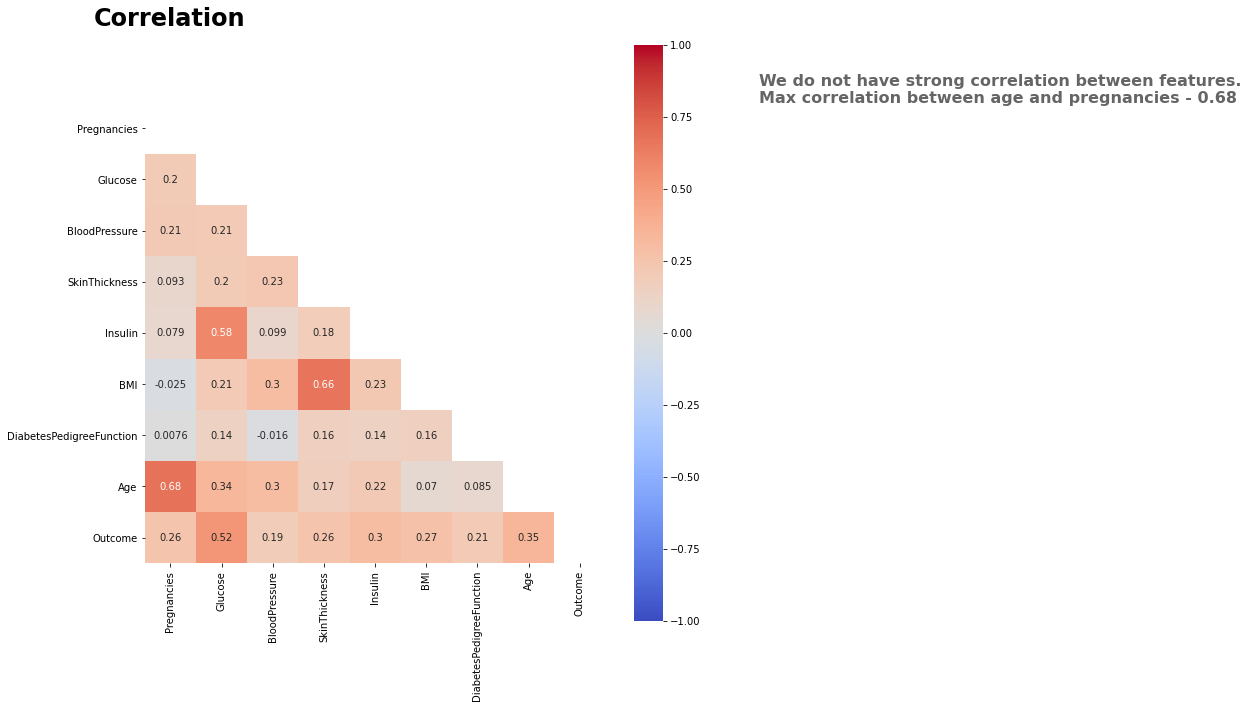

In [13]:
df['Outcome'].replace({'No' : 0, 'Yes' : 1}, inplace=True)
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

# fig
fig= plt.figure(figsize=(8, 8))

# mask
mask = np.triu(df.corr())

# axes 
axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(df.dropna().corr(), annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='coolwarm', linecolor='white',
            cbar_kws= {'orientation': 'vertical'}, ax=axes) 

# annotate
axes.text(12, 0, f'''We do not have strong correlation between features.
Max correlation between age and pregnancies - {round(df.dropna().corr()['Pregnancies'][7], 2)}''', fontsize=16, fontweight='bold', color='black', alpha=0.6)

# title
axes.text(-1, -1.5, 'Correlation', color='black', fontsize=24, fontweight='bold')

fig.show()

**And so we do not have strong correlation between features.**

# Preparing and models
**We have a lot of NaN values and I suggest replacing them all with the median values by Outcome. Also we have unbalanced target.**

In [14]:
df.drop('Age_category', axis=1, inplace=True)

df_no = df[df['Outcome']==0]
df_yes = df[df['Outcome']==1]

# Glucose
df_no['Glucose'].fillna(df_no['Glucose'].median(),inplace=True)
df_yes['Glucose'].fillna(df_yes['Glucose'].median(),inplace=True)

# BloodPressure
df_no['BloodPressure'].fillna(df_no['BloodPressure'].median(),inplace=True)
df_yes['BloodPressure'].fillna(df_yes['BloodPressure'].median(),inplace=True)

# SkinThickness
df_no['SkinThickness'].fillna(df_no['SkinThickness'].median(),inplace=True)
df_yes['SkinThickness'].fillna(df_yes['SkinThickness'].median(),inplace=True)

# Insulin
df_no['Insulin'].fillna(df_no['Insulin'].median(),inplace=True)
df_yes['Insulin'].fillna(df_yes['Insulin'].median(),inplace=True)

#BMI
df_no['BMI'].fillna(df_no['BMI'].median(),inplace=True)
df_yes['BMI'].fillna(df_yes['BMI'].median(),inplace=True)

# concat
df = pd.concat([df_no, df_yes])

# scaler
scaler = StandardScaler()
norm = scaler.fit_transform(df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']])
df_norm = pd.DataFrame({'Pregnancies': norm[ :, 0], 'Glucose' : norm[ :, 1], 'BloodPressure' : norm[ :, 2], 'SkinThickness' : norm[ :, 3],
                       'Insulin' : norm[ :, 4], 'BMI' : norm[ :, 5], 'DiabetesPedigreeFunction' : norm[ :, 5], 'Age' : norm[ :, 6]}, 
                       columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
df_norm['Outcome'] = df['Outcome']

# split
x = df.drop(['Outcome'], axis=1)
y = df['Outcome']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# os
os = SMOTE(random_state=42)
columns = x_train.columns
os_data_x,os_data_y = os.fit_resample(x_train, y_train.ravel())

In [15]:
# log
log_params = {'penalty':['l1', 'l2'], 
              'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 100], 
              'solver':['liblinear', 'saga']}
log_model = GridSearchCV(LogisticRegression(), log_params, cv=5)
log_model.fit(os_data_x, os_data_y)
log_predict = log_model.predict(x_test)
log_cm = confusion_matrix(y_test, log_predict)
log_score = log_model.best_score_

In [16]:
# knn
knn_params = {'n_neighbors': list(range(3, 20, 2)),
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
          'metric':['euclidean', 'manhattan', 'chebyshev', 'minkowski']}
knn_model = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn_model.fit(os_data_x, os_data_y)
knn_predict = knn_model.predict(x_test)
knn_cm = confusion_matrix(y_test, knn_predict)
knn_score = knn_model.best_score_

In [17]:
# svc
svc_params = {'C': [0.001, 0.01, 0.1, 1],
              'kernel': [ 'linear' , 'poly' , 'rbf' , 'sigmoid' ]}
svc_model = GridSearchCV(SVC(), svc_params, cv=5)
svc_model.fit(os_data_x, os_data_y)
svc_predict = svc_model.predict(x_test)
svc_cm = confusion_matrix(y_test, svc_predict)
svc_score = svc_model.best_score_

In [18]:
# dt
dt_params = {'criterion' : ['gini', 'entropy'],
              'splitter': ['random', 'best'], 
              'max_depth': [3, 5, 7, 9, 11, 13]}
dt_model = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=5)
dt_model.fit(os_data_x, os_data_y)
dt_predict = dt_model.predict(x_test)
dt_cm = confusion_matrix(y_test, dt_predict)
dt_score = dt_model.best_score_

In [19]:
# rf
rf_params = {'criterion' : ['gini', 'entropy'],
             'n_estimators': list(range(5, 26, 5)),
             'max_depth': list(range(3, 20, 2))}
rf_model = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
rf_model.fit(os_data_x, os_data_y)
rf_predict = rf_model.predict(x_test)
rf_cm = confusion_matrix(y_test, rf_predict)
rf_score = rf_model.best_score_

In [20]:
# sgd
sgd_params = {'loss' : ['hinge', 'log', 'squared_hinge', 'modified_huber'],
              'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10],
              'penalty' : ['l2', 'l1', 'none']}
sgd_model = GridSearchCV(SGDClassifier(max_iter=10000), sgd_params, cv=5)
sgd_model.fit(os_data_x, os_data_y)
sgd_predict = sgd_model.predict(x_test)
sgd_cm = confusion_matrix(y_test, sgd_predict)
sgd_score = sgd_model.best_score_

In [21]:
# lgb
lgb_params = {'n_estimators': [5, 10, 15, 20, 25, 50, 100],
                   'learning_rate': [0.01, 0.05, 0.1],
                   'num_leaves': [7, 15, 31],
                  }
lgb_model = GridSearchCV(LGBMClassifier(), lgb_params, cv=5)
lgb_model.fit(os_data_x, os_data_y)
lgb_predict = lgb_model.predict(x_test)
lgb_cm = confusion_matrix(y_test, lgb_predict)
lgb_score = lgb_model.best_score_

In [22]:
# xgb
xgb_params = {'max_depth': [3, 5, 7, 9],
              'n_estimators': [5, 10, 15, 20, 25, 50, 100],
              'learning_rate': [0.01, 0.05, 0.1]}
xgb_model = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss'), xgb_params, cv=5)
xgb_model.fit(os_data_x, os_data_y)
xgb_predict = xgb_model.predict(x_test)
xgb_cm = confusion_matrix(y_test, xgb_predict)
xgb_score = xgb_model.best_score_

In [23]:
# cb
cb_params = {'learning_rate': [0.01, 0.05, 0.1],
             'depth': [3, 5, 7, 9]}
cb_model = GridSearchCV(cb.CatBoostClassifier(verbose=False), cb_params, cv=5)
cb_model.fit(os_data_x, os_data_y)
cb_predict = cb_model.predict(x_test)
cb_cm = confusion_matrix(y_test, cb_predict)
cb_score = cb_model.best_score_

# Results

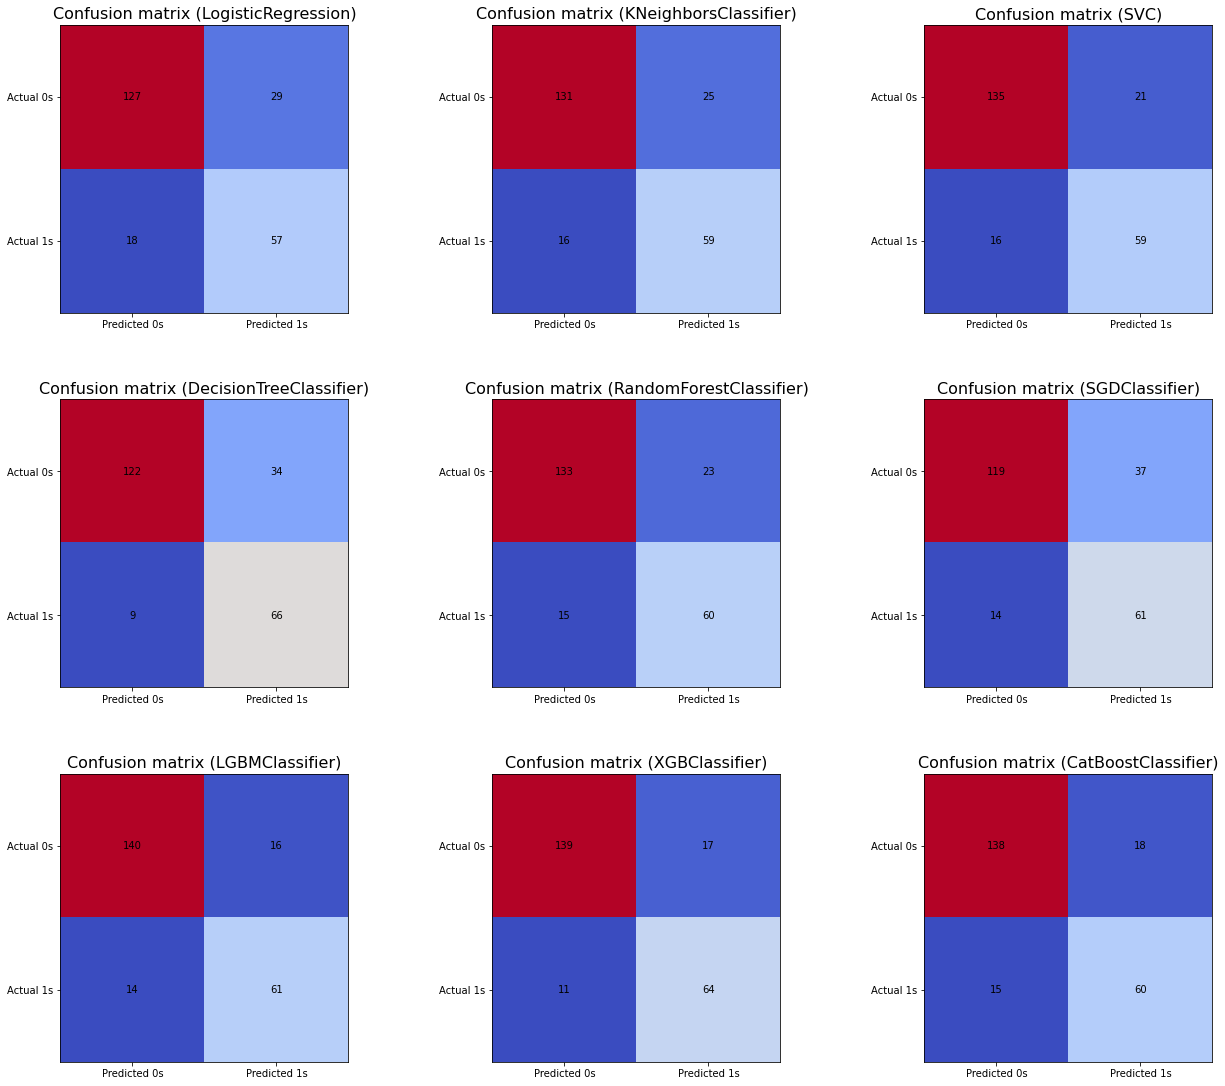

In [24]:
# Results

figure = plt.figure()
axes1 = figure.add_axes([0, 0, 1, 1]) # log_model
axes2 = figure.add_axes([1, 0, 1, 1]) # knn_model
axes3 = figure.add_axes([2, 0, 1, 1]) # svc_model
axes4 = figure.add_axes([0, -1.3, 1, 1]) # dt_model
axes5 = figure.add_axes([1, -1.3, 1, 1]) # rf_model
axes6 = figure.add_axes([2, -1.3, 1, 1]) # rf_model
axes7 = figure.add_axes([0, -2.6, 1, 1]) # lgb_model
axes8 = figure.add_axes([1, -2.6, 1, 1]) # xgb_model
axes9 = figure.add_axes([2, -2.6, 1, 1]) # xgb_model

# log_model
axes1.imshow(log_cm, cmap='coolwarm')
axes1.grid(False)
axes1.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axes1.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axes1.set_title('Confusion matrix (LogisticRegression)', fontsize=16)
for i in range(2):
    for j in range(2):
        axes1.text(j, i, log_cm[i, j], ha='center', va='center', color='black')

# knn_model
axes2.imshow(knn_cm, cmap='coolwarm')
axes2.grid(False)
axes2.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axes2.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axes2.set_title('Confusion matrix (KNeighborsClassifier)', fontsize=16)
for i in range(2):
    for j in range(2):
        axes2.text(j, i, knn_cm[i, j], ha='center', va='center', color='black')

# svc_model
axes3.imshow(svc_cm, cmap='coolwarm')
axes3.grid(False)
axes3.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axes3.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axes3.set_title('Confusion matrix (SVC)', fontsize=16)
for i in range(2):
    for j in range(2):
        axes3.text(j, i, svc_cm[i, j], ha='center', va='center', color='black')

# knn_model       
axes4.imshow(dt_cm, cmap='coolwarm')
axes4.grid(False)
axes4.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axes4.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axes4.set_title('Confusion matrix (DecisionTreeClassifier)', fontsize=16)
for i in range(2):
    for j in range(2):
        axes4.text(j, i, dt_cm[i, j], ha='center', va='center', color='black')

# rf_model       
axes5.imshow(rf_cm, cmap='coolwarm')
axes5.grid(False)
axes5.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axes5.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axes5.set_title('Confusion matrix (RandomForestClassifier)', fontsize=16)
for i in range(2):
    for j in range(2):
        axes5.text(j, i, rf_cm[i, j], ha='center', va='center', color='black')
        
# sgd_model       
axes6.imshow(sgd_cm, cmap='coolwarm')
axes6.grid(False)
axes6.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axes6.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axes6.set_title('Confusion matrix (SGDClassifier)', fontsize=16)
for i in range(2):
    for j in range(2):
        axes6.text(j, i, sgd_cm[i, j], ha='center', va='center', color='black')

# lgb_model       
axes7.imshow(lgb_cm, cmap='coolwarm')
axes7.grid(False)
axes7.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axes7.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axes7.set_title('Confusion matrix (LGBMClassifier)', fontsize=16)
for i in range(2):
    for j in range(2):
        axes7.text(j, i, lgb_cm[i, j], ha='center', va='center', color='black')
        
# xgb_model       
axes8.imshow(xgb_cm, cmap='coolwarm')
axes8.grid(False)
axes8.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axes8.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axes8.set_title('Confusion matrix (XGBClassifier)', fontsize=16)
for i in range(2):
    for j in range(2):
        axes8.text(j, i, xgb_cm[i, j], ha='center', va='center', color='black')

# cb_model       
axes9.imshow(cb_cm, cmap='coolwarm')
axes9.grid(False)
axes9.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
axes9.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
axes9.set_title('Confusion matrix (CatBoostClassifier)', fontsize=16)
for i in range(2):
    for j in range(2):
        axes9.text(j, i, cb_cm[i, j], ha='center', va='center', color='black')

In [25]:
models = ['LogisticRegression', 'KNeighborsClassifier', 'SVC', 'DecisionTreeClassifier', 
          'RandomForestClassifier', 'SGDClassifier', 'LGBMClassifier', 'XGBClassifier', 'CatBoostClassifier']
scores = [log_score, knn_score, svc_score, dt_score, rf_score, sgd_score, lgb_score, xgb_score, cb_score]
score_table = pd.DataFrame({'Model':models, 'Score':scores})
score_table.sort_values(by='Score', axis=0, ascending=False)

,Model,Score
8,CatBoostClassifier,0.925897
4,RandomForestClassifier,0.920110
7,XGBClassifier,0.915730
1,KNeighborsClassifier,0.914271
6,LGBMClassifier,0.911404
3,DecisionTreeClassifier,0.877912
2,SVC,0.861885
0,LogisticRegression,0.783339
5,SGDClassifier,0.720988
